In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

frac_df = pd.read_csv('../data/FMT/FMT1/Li.txt', sep='\t', header=0, index_col=0)


In [2]:
p_cutoff = 0.05
days = [0, 2, 14, 42, 84]
# compute frac and t
tmp = 'Fraction of donor specific strains ({} days post FMT)'
frac = []
t = []
for day in days:
    if day == 0:
        continue
    post_day = tmp.format(day)
    frac += list(frac_df[post_day])
    t += [day] * len(frac_df)

odf = pd.DataFrame()

data_df = pd.DataFrame(columns = ['fr', 'td', 'fd'])
data_df['fr'] = frac_df['preFMT FR']
data_df['fd'] = frac_df['preFMT FD']
data_df['td'] = frac_df['preFMT TD']

for c in data_df.columns:
    v = []
    for day in days:
        if day == 0:
            continue
        v += list(data_df[c])
    
    df = pd.DataFrame()
    df['frac'] = frac
    df[c] = v
    df['t'] = t
    X = df[[c, 't']]
    y = df['frac']
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    result = model.fit()
    #print(result.pvalues)
    odf.loc[c, 'F-pvalue'] = result.f_pvalue
    for var in result.pvalues.index:
        odf.loc[c, "{}_co".format(var)] = result.params[var]
        odf.loc[c, "{}_p".format(var)] = result.pvalues[var]

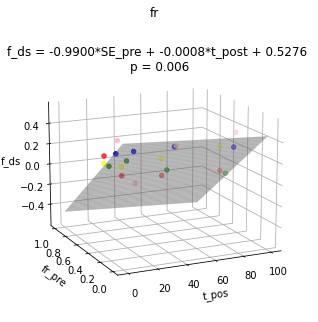

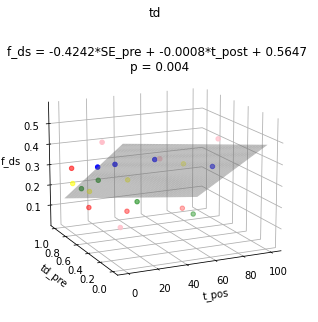

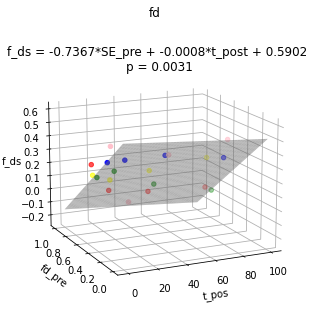

In [3]:
color_dict = {
    'Subject1/FMT1': 'r', 
    'Subject2/FMT2': 'g', 
    'Subject3//FMT3': 'b', 
    'Subject4/FMT4': 'pink', 
    'Subject5//FMT5':'yellow', 
}
formula_tmp = 'f_ds = {:.4f}*SE_pre + {:.4f}*t_post + {:.4f} \np = {:.4}'
for idc in odf.index:
    idc_co = odf.loc[idc, '{}_co'.format(idc)]
    t_co = odf.loc[idc, 't_co']
    const = odf.loc[idc, 'const_co']
    p_value = round(odf.loc[idc, 'F-pvalue'], 4)
    idc_v = np.linspace(0, 1, 100)
    t = np.linspace(0, 100, 100)
    X, Y = np.meshgrid(t, idc_v)
    f = idc_co*Y + t_co*X + const
    formula = formula_tmp.format(idc_co, t_co, const, p_value)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, f, color='#AAAAAA', alpha=0.5)

    # 设置坐标轴标签
    ax.set_xlabel('t_pos')
    ax.set_ylabel("{}_pre".format(idc))
    ax.set_zlabel('f_ds')

    tmp = 'Fraction of donor specific strains ({} days post FMT)'
    frac = []
    t = []
    for day in days:
        if day == 0:
            continue
        post_day = tmp.format(day)
        frac += list(frac_df[post_day])
        t += [day] * len(frac_df)
    idc_v = []
    colors = []
    for day in days:
        if day == 0:
            continue
        for i in data_df.index:
            value = data_df.loc[i, idc]
            idc_v.append(value)
            colors.append(color_dict[i])
    df = pd.DataFrame()
    ax.scatter(t, idc_v, frac, c = colors)
    ax.set_title(formula, y = 0.95)
    ax.view_init(elev=15, azim=245)
    ax.xaxis.set_pane_color((1, 1, 1, 1))
    ax.yaxis.set_pane_color((1, 1, 1, 1))
    ax.zaxis.set_pane_color((1, 1, 1, 1))
    
    plt.suptitle(idc)
    plt.show()